In [20]:
import pandas as pd
import numpy as np
import re # regex to detect username, url, html entity 
import nltk
import os

# Set NLTK data path
nltk.data.path.append(os.path.expanduser('~/nltk_data'))

# Download ALL required NLTK data
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('tokenizers/punkt/english.pickle', quiet=True)

# Import after downloading
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Initialize stopwords
stop_words = set(stopwords.words('english'))
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.utils import to_categorical
from keras import backend as K

[nltk_data] Error loading tokenizers/punkt/english.pickle: Package
[nltk_data]     'tokenizers/punkt/english.pickle' not found in index


In [42]:
data = pd.read_csv("train.csv")
data[data['class'] == 1]['tweet'].iloc[22]

'" fuck no that bitch dont even suck dick " &#128514;&#128514;&#128514; the Kermit videos bout to fuck IG up'

In [3]:
# dataset shape to know how many tweets in the datasets
print(f"num of tweets: {data.shape}")

# extract the text and labels
tweet = list(data['tweet'])
labels = list(data['class'])

num of tweets: (24783, 6)


In [4]:
#notes : all of the function taking 1 text at a time
stop_words = set(stopwords.words('english'))
# add rt to remove retweet in dataset (noise)
stop_words.add("rt")

# remove html entity:
def remove_entity(raw_text):
    entity_regex = r"&[^\s;]+;"
    text = re.sub(entity_regex, "", raw_text)
    return text

# change the user tags
def change_user(raw_text):
    regex = r"@([^ ]+)"
    text = re.sub(regex, "user", raw_text)

    return text

# remove urls
def remove_url(raw_text):
    url_regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    text = re.sub(url_regex, '', raw_text)

    return text

# remove unnecessary symbols
def remove_noise_symbols(raw_text):
    text = raw_text.replace('"', '')
    text = text.replace("'", '')
    text = text.replace("!", '')
    text = text.replace("`", '')
    text = text.replace("..", '')

    return text

# remove stopwords
def remove_stopwords(raw_text):
    tokenize = nltk.word_tokenize(raw_text)
    text = [word for word in tokenize if not word.lower() in stop_words]
    text = " ".join(text)

    return text

## this function in to clean all the dataset by utilizing all the function above
def preprocess(datas):
    clean = []
    # change the @xxx into "user"
    clean = [change_user(text) for text in datas]
    # remove emojis (specifically unicode emojis)
    clean = [remove_entity(text) for text in clean]
    # remove urls
    clean = [remove_url(text) for text in clean]
    # remove trailing stuff
    clean = [remove_noise_symbols(text) for text in clean]
    # remove stopwords
    clean = [remove_stopwords(text) for text in clean]

    return clean

In [5]:
# call the cleaning function
clean_tweet = preprocess(tweet)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(clean_tweet, labels, test_size=0.2, random_state=42)

In [7]:
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

19826
4957
19826
4957


In [8]:
## Tokenizing -> basically we use tokenisation for many things, its commonly used for feature extraction in preprocessing. btw idk how it works as feature extraction tho :(
# declare the tokenizer
tokenizer = Tokenizer()
# build the vocabulary based on train dataset
tokenizer.fit_on_texts(X_train)
# tokenize the train and test dataset
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# vocabulary size (num of unique words) -> will be used in embedding layer
vocab_size = len(tokenizer.word_index) + 1

In [9]:
print(len(X_train))
print(len(X_test))
vocab_size

19826
4957


18671

In [10]:
## Padding -> to uniform the datas
max_length = max(len(seq) for seq in X_train)

# to test an outlier case (if one of the test dataset has longer length)
for x in X_test:
    if len(x) > max_length:
        print(f"an outlier detected: {x}")

X_train = pad_sequences(X_train, maxlen = max_length)
X_test = pad_sequences(X_test, maxlen = max_length)

In [31]:
max_length

26

In [11]:
# create hot_labels (idk whty tapi ini penting, kalo ga bakal error)
y_test = to_categorical(y_test, num_classes=3)
y_train = to_categorical(y_train, num_classes=3)

In [12]:
y_test[2]

array([0., 0., 1.])

In [13]:
# another look on the number of tweet in test and training data

print(f"num test tweet: {y_test.shape[0]}")
print(f"num train tweet: {y_train.shape[0]}")

num test tweet: 4957
num train tweet: 19826


#  Building the model


In [15]:
# change dis if u want
output_dim = 200

# LSTM model architechture (CNN + LSTM)
model = Sequential([
    # embedding layer is like idk
    Embedding(vocab_size, output_dim, input_length=max_length),
    # lstm for xxx
    LSTM(64, dropout=0.3, recurrent_dropout=0.3),
    # dropout to prevent overfitting
    Dropout(0.5),
    # dense to connect the previous output with current layer
    Dense(128, activation="relu"),
    # dropout to prevent overfitting
    Dropout(0.5),
    # this is output layer, with 3 class (0, 1, 2)
    Dense(3, activation="softmax"),
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',f1,precision, recall])

/Users/so/Documents/ucu/MLOPS/PO2/venv/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [16]:
# checking the model parameters
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Train the model
model_history = model.fit(
    X_train,
    y_train,
    batch_size = 64,
    epochs=10,
    validation_data=(X_test, y_test)
)

Epoch 1/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 34s 85ms/step - accuracy: 0.7930 - f1: 0.7130 - loss: 0.6259 - precision: 0.7599 - recall: 0.6899 - val_accuracy: 0.8876 - val_f1: 0.8871 - val_loss: 0.3355 - val_precision: 0.8974 - val_recall: 0.8771
Epoch 2/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 23s 75ms/step - accuracy: 0.9099 - f1: 0.9104 - loss: 0.2733 - precision: 0.9222 - recall: 0.8990 - val_accuracy: 0.8882 - val_f1: 0.8879 - val_loss: 0.3193 - val_precision: 0.9012 - val_recall: 0.8751
Epoch 3/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 27s 88ms/step - accuracy: 0.9442 - f1: 0.9448 - loss: 0.1583 - precision: 0.9511 - recall: 0.9387 - val_accuracy: 0.8729 - val_f1: 0.8715 - val_loss: 0.3952 - val_precision: 0.8762 - val_recall: 0.8670
Epoch 4/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 27s 88ms/step - accuracy: 0.9632 - f1: 0.9633 - loss: 0.1103 - precision: 0.9651 - recall: 0.9615 - val_accuracy: 0.8705 - val_f1: 0.8711 - val_loss: 0.4828 - val_precision: 0.8736 - val_recall: 0.8687
Epoch 5/10
310/310 ━━━━━━━━━━━━━

In [15]:
print("X_train:", type(X_train), X_train.shape)

X_train: <class 'numpy.ndarray'> (19826, 26)


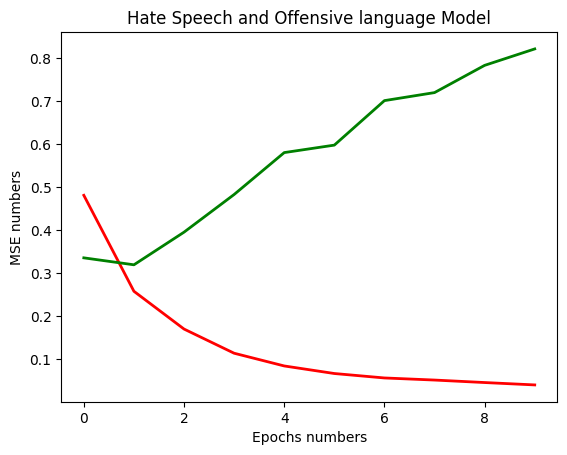

In [19]:
import matplotlib.pyplot as plt
hist = model.history.history
plt.plot(hist['loss'],'r',linewidth=2, label='Training loss')
plt.plot(hist['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('Hate Speech and Offensive language Model')
plt.xlabel('Epochs numbers')
plt.ylabel('MSE numbers')
plt.show()

In [23]:
sample = "fuck this"

sample_clean = preprocess([sample])   
sample_seq = tokenizer.texts_to_sequences(sample_clean)
sample_pad = pad_sequences(sample_seq, maxlen=max_length)

prediction = model.predict(sample_pad)
predicted_class = prediction.argmax(axis=1)[0]
print(f"Predicted class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Predicted class: 1


In [26]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test).argmax(axis=1)
y_true = y_test.argmax(axis=1)
print(classification_report(y_true, y_pred))


155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
              precision    recall  f1-score   support

           0       0.31      0.28      0.29       290
           1       0.91      0.93      0.92      3832
           2       0.80      0.78      0.79       835

    accuracy                           0.86      4957
   macro avg       0.68      0.66      0.67      4957
weighted avg       0.86      0.86      0.86      4957



In [28]:
import pickle

with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)


In [30]:
model.save('my_model.keras')